In [1]:
#import statements
import os
from imutils import paths
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from keras.callbacks import  ModelCheckpoint
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split



In [2]:
imagePaths = list(paths.list_images('/content/drive/MyDrive/Maskrecognition'))

data = []
labels = []

#to extract images from the folder and assigning the labels
for imagePath in imagePaths:
  #get the label from the class folder name
  label = imagePath.split(os.path.sep)[-2]

  #image preprocessing
  img = load_img(imagePath, target_size=(224,224))
  img = img_to_array(img)
  img = preprocess_input(img)

  #append the image and label to the lists
  data.append(img)
  labels.append(label)

data = np.array(data, dtype="float32")
labels = np.array(labels)


In [3]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [4]:
#split the data into train, val, and test sets
#70% train, 20%val, 10%test
trainX, data1, trainY, labels1 = train_test_split(data, labels,test_size=0.30, stratify=labels, random_state=42)

valX, testX, valY, testY = train_test_split(data1, labels1, test_size=0.334, stratify=labels1, random_state=42)

In [5]:
#image augmentation for training data to increase the num of samples.

aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

val_aug = ImageDataGenerator(rescale=1.0/255)

In [6]:
#building a network architecture
model =Sequential([
    Conv2D(150, (3,3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2,2),
    
    Conv2D(150, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Flatten(),
    Dropout(0.5),
    Dense(50, activation='relu'),
    Dense(2, activation='softmax')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [7]:
checkpoint = ModelCheckpoint('model2-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')

In [8]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
  epochs=EPOCHS,
	validation_data= (valX, valY),
  callbacks= [checkpoint])


[INFO] training head...
Epoch 1/20
92/92 [==============================] - 46s 385ms/step - loss: 0.8541 - acc: 0.6508 - val_loss: 0.3463 - val_acc: 0.8838
INFO:tensorflow:Assets written to: model2-001.model/assets
Epoch 2/20
92/92 [==============================] - 34s 368ms/step - loss: 0.4236 - acc: 0.8497 - val_loss: 0.2669 - val_acc: 0.9162
INFO:tensorflow:Assets written to: model2-002.model/assets
Epoch 3/20
92/92 [==============================] - 34s 371ms/step - loss: 0.3614 - acc: 0.8697 - val_loss: 0.2579 - val_acc: 0.9150
INFO:tensorflow:Assets written to: model2-003.model/assets
Epoch 4/20
92/92 [==============================] - 34s 372ms/step - loss: 0.3305 - acc: 0.8868 - val_loss: 0.2199 - val_acc: 0.9521
INFO:tensorflow:Assets written to: model2-004.model/assets
Epoch 5/20
92/92 [==============================] - 34s 371ms/step - loss: 0.2845 - acc: 0.8962 - val_loss: 0.2056 - val_acc: 0.9377
INFO:tensorflow:Assets written to: model2-005.model/assets
Epoch 6/20
92/92

In [9]:
from sklearn.metrics import classification_report
print("[INFO] evaluating network...")
predIdxs = model.predict(valX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)

print(classification_report(valY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))


[INFO] evaluating network...
              precision    recall  f1-score   support

   with_mask       0.94      0.96      0.95       408
without_mask       0.96      0.94      0.95       427

    accuracy                           0.95       835
   macro avg       0.95      0.95      0.95       835
weighted avg       0.95      0.95      0.95       835



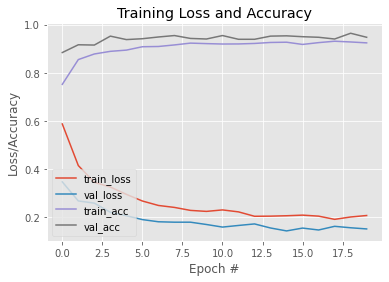

In [10]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
#plt.savefig(args["plot"])